In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Set the style for Seaborn plots
sns.set_theme(style="white", rc={"axes.labelsize": 22, "xtick.labelsize": 18, "ytick.labelsize": 18})
sns.set_context("talk", font_scale=1.5)

# Get 4 distinct colors from Seaborn's Set2 palette
colors = sns.color_palette("colorblind", 4)

# Assign colors to each dataset
color_map = {
    "3D Manual Tracking": colors[1],
    "3D BTrack Tracking": colors[3], 
    "2D BTrack Tracking": colors[2], 
    "Simulation": colors[0],
}

# Simulating without Markov chains from data

Step 25/100 completed
Step 50/100 completed
Step 75/100 completed
Step 100/100 completed
Simulation completed: 100 steps


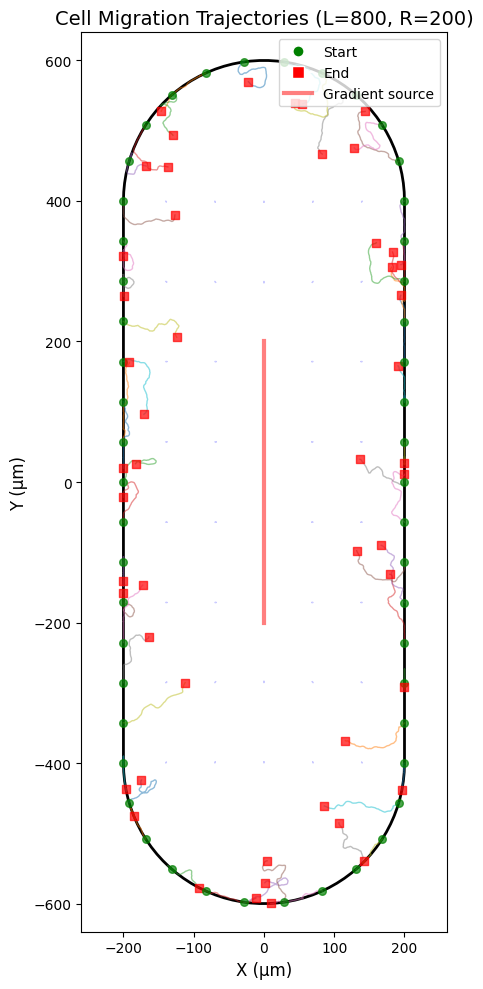

(<Figure size 600x1000 with 1 Axes>,
 <Axes: title={'center': 'Cell Migration Trajectories (L=800, R=200)'}, xlabel='X (μm)', ylabel='Y (μm)'>)

In [4]:
from simulation import Simulation
from visualization import plot_trajectories, create_animation, plot_cell_statistics
from analysis import calculate_autocorrelation, calculate_msd

# Create simulation with proper stadium parameters
sim = Simulation(
    n_cells=50,
    stadium_L=800,          # Length of straight walls
    stadium_R=200,          # Radius of semicircles
    source_length=400,      # Length of gradient line source
    chemotaxis_strength=0.0,
    repulsion_strength=0.2,
    starting_positions='perimeter'
)

# Run simulation
sim.run(n_steps=100)

# Visualize
plot_trajectories(sim)

d:\David\endoderm_migration\cell_migration_simulation\MCmigrate\MCmigrate\analysis.py:47: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(dot)


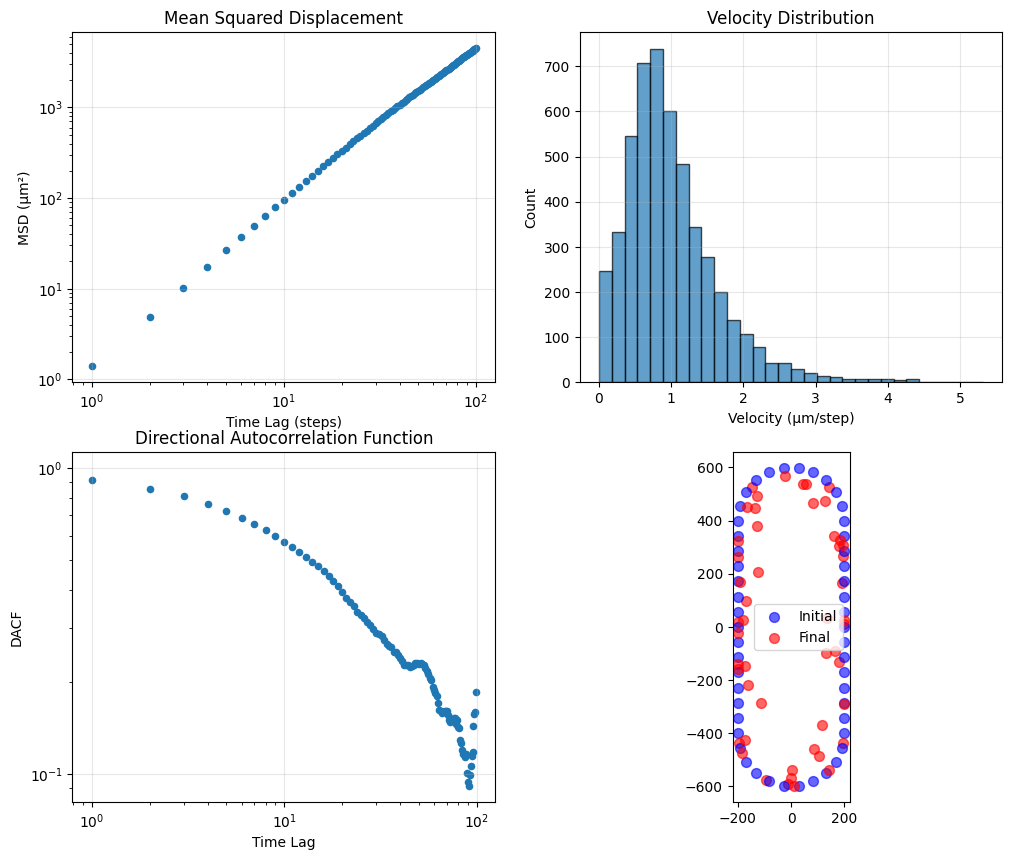

In [5]:
plot_cell_statistics(sim)

# Simulating with Markov chains from data

In [6]:
from markov import MarkovChain
from simulation import Simulation
from scipy.stats import lognorm

# Load data
data = pd.read_csv(r'D:\David\endoderm_migration\raw_data\220125_2DFACS_FOXA2positive_lateday2\tracks_df_220125_2DFACS_FOXA2positive_lateday2.csv')
data = data[['track_id', 'normalized_time', 'x_microns', 'y_microns']]
data = data.rename(columns={'normalized_time': 'step', 'x_microns': 'x', 'y_microns': 'y'})
data['dx'] = data.groupby('track_id')['x'].diff()
data['dy'] = data.groupby('track_id')['y'].diff()
data['theta'] = np.arctan2(data['dy'], data['dx'])
data['dt'] = 10
data['v_x'] = data['dx'] / data['dt']
data['v_y'] = data['dy'] / data['dt']
data['velocity'] = np.sqrt(data['dx']**2 + data['dy']**2)/data['dt']
data['velocity'] = data['velocity'].replace([np.inf, -np.inf], np.nan)

# Fit a log-normal distribution to the velocity data
velocity_data = data['velocity'].dropna().values
velocity_data = velocity_data[velocity_data > 0]
shape, loc, scale = lognorm.fit(velocity_data, floc=0)

tracks = [group[['x', 'y']].values 
          for _, group in data.groupby('track_id')]

# Fit Markov chain
B = 24  # Number of angle bins
n = 10  # Number of previous angles to consider

mc = MarkovChain()
mc.fit(tracks, B=B, n=n)

Markov chain fitted: 355123 states from 33967 tracks


In [23]:
# Run simulation with fitted model
sim = Simulation(n_cells=100, markov_chain=mc, starting_positions='uniform', stadium_L=800, stadium_R=200, source_length=400, chemotaxis_strength=0.0, repulsion_strength=0.0, interaction_radius=1.0)
sim.run(n_steps=data['step'].max())
sim_df = sim.get_dataframe()

Step 25/242 completed
Step 50/242 completed
Step 75/242 completed
Step 100/242 completed
Step 125/242 completed
Step 150/242 completed
Step 175/242 completed
Step 200/242 completed
Step 225/242 completed
Simulation completed: 242 steps


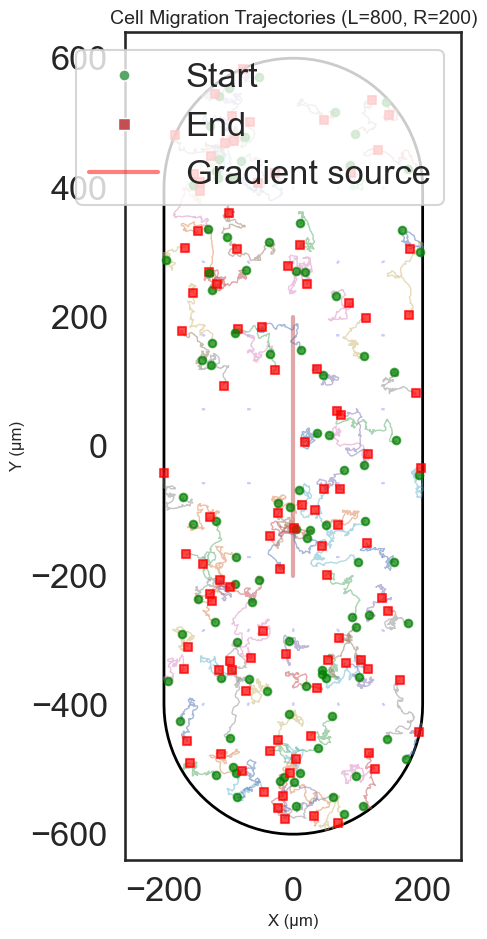

Animation saved to migration.gif


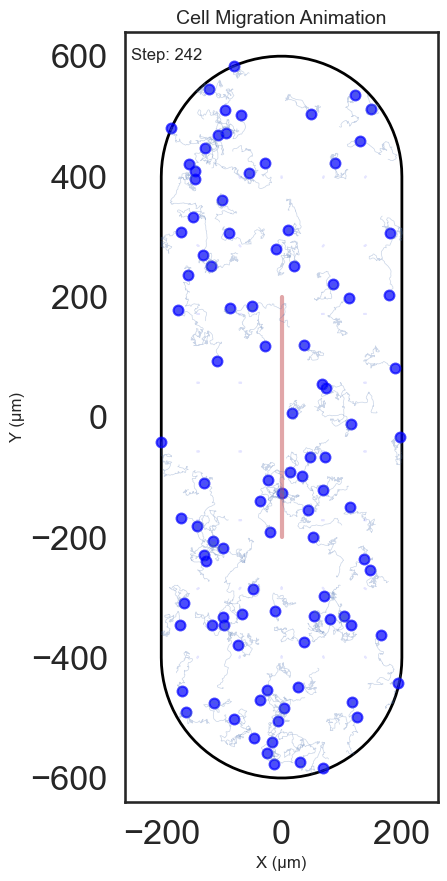

d:\David\endoderm_migration\cell_migration_simulation\MCmigrate\MCmigrate\analysis.py:47: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(dot)


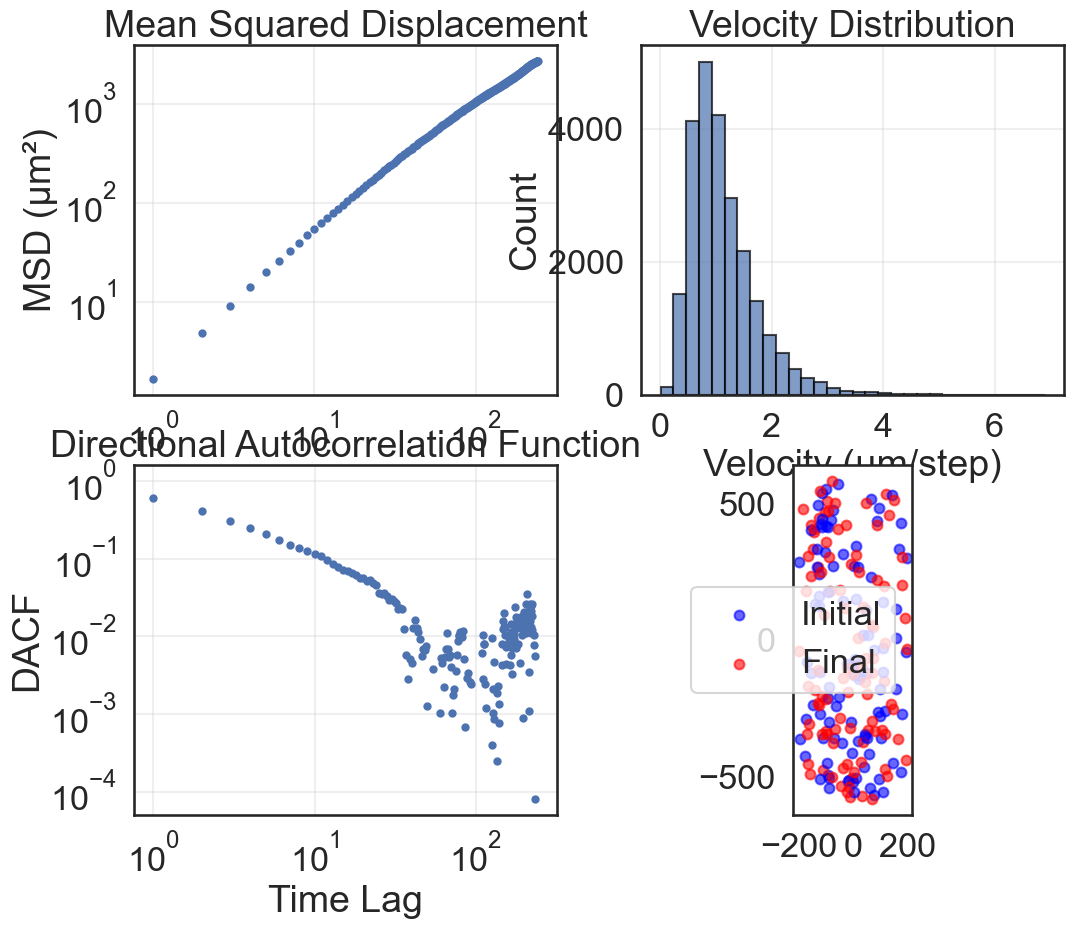

In [24]:
from visualization import plot_trajectories, create_animation, plot_cell_statistics

# Plot trajectories
plot_trajectories(sim, show_gradient=True)

# # Create animation
anim = create_animation(sim, save_path='migration.gif')

# Plot statistics
plot_cell_statistics(sim)

In [25]:
dacf_exp = calculate_autocorrelation(data)
sim_dacf = calculate_autocorrelation(sim_df)

msd_exp = calculate_msd(data)
msd_sim = calculate_msd(sim_df)

d:\David\endoderm_migration\cell_migration_simulation\MCmigrate\MCmigrate\analysis.py:47: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(dot)
d:\David\endoderm_migration\cell_migration_simulation\MCmigrate\MCmigrate\analysis.py:47: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(dot)


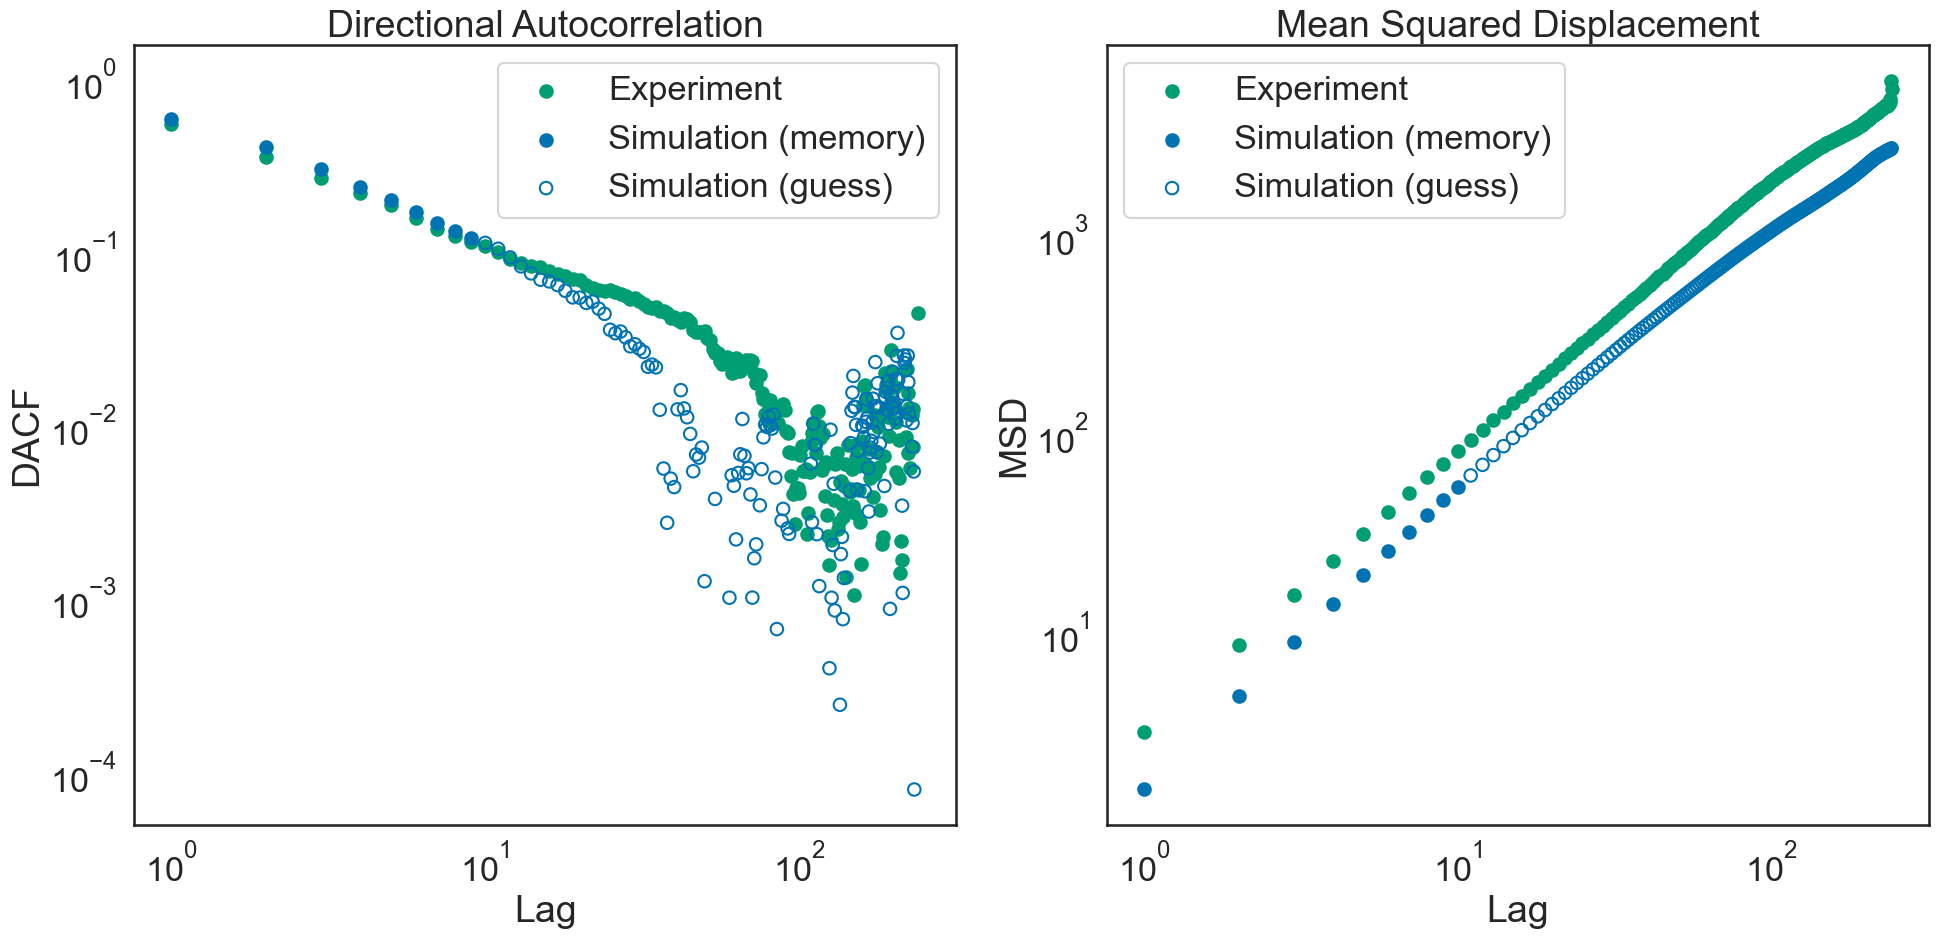

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# DACF plot
n_memory = 10  # Number of memory steps (as used in MarkovChain fit)
axes[0].scatter(dacf_exp['lag'], dacf_exp['dacf'], label='Experiment', color=color_map["2D BTrack Tracking"], marker='o')
axes[0].scatter(sim_dacf['lag'][:n_memory], sim_dacf['dacf'][:n_memory], label='Simulation (memory)', color=color_map["Simulation"], marker='o')
axes[0].scatter(sim_dacf['lag'][n_memory:], sim_dacf['dacf'][n_memory:], label='Simulation (guess)', facecolors='none', edgecolors=color_map["Simulation"], marker='o')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('DACF')
axes[0].set_title('Directional Autocorrelation')
axes[0].legend()

# MSD plot
axes[1].scatter(msd_exp['lag'], msd_exp['msd'], label='Experiment', color=color_map["2D BTrack Tracking"], marker='o')
axes[1].scatter(msd_sim['lag'][:n_memory], msd_sim['msd'][:n_memory], label='Simulation (memory)', color=color_map["Simulation"], marker='o')
axes[1].scatter(msd_sim['lag'][n_memory:], msd_sim['msd'][n_memory:], label='Simulation (guess)', facecolors='none', edgecolors=color_map["Simulation"], marker='o')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('MSD')
axes[1].set_title('Mean Squared Displacement')
axes[1].legend()

plt.tight_layout()
plt.show()

In [33]:
sim_df['velocity'] = np.sqrt(sim_df['v_x']**2 + sim_df['v_y']**2)

In [36]:
sim_df['dx'] = sim_df.groupby('track_id')['x'].diff()
sim_df['dy'] = sim_df.groupby('track_id')['y'].diff()

sim_df['velocity'] = np.sqrt(sim_df['dx']**2 + sim_df['dy']**2)/10  # Assuming dt=10 as in experimental data

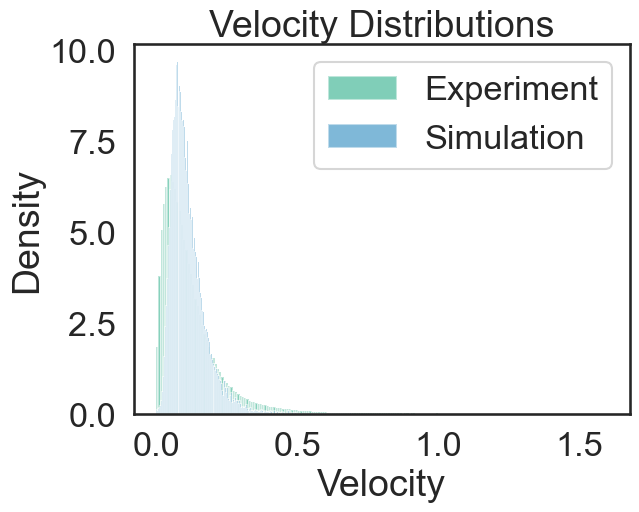

In [47]:
# COMPARE VELOCITY DISTRIBUTIONS
exp_velocities = data['velocity'].dropna()
exp_velocities = exp_velocities[exp_velocities > 0]
sim_velocities = sim_df['velocity'].dropna()
sim_velocities = sim_velocities[sim_velocities > 0]

plt.hist(exp_velocities, bins=200, density=True, alpha=0.5, label='Experiment', color=color_map["2D BTrack Tracking"])
plt.hist(sim_velocities, bins=200, density=True, alpha=0.5, label='Simulation', color=color_map["Simulation"])
plt.xlabel('Velocity')
plt.ylabel('Density')
plt.title('Velocity Distributions')
plt.legend()
plt.show()

In [48]:
np.mean(exp_velocities)/np.mean(sim_velocities)  # Scaling factor to match means

np.float64(1.123655025672449)

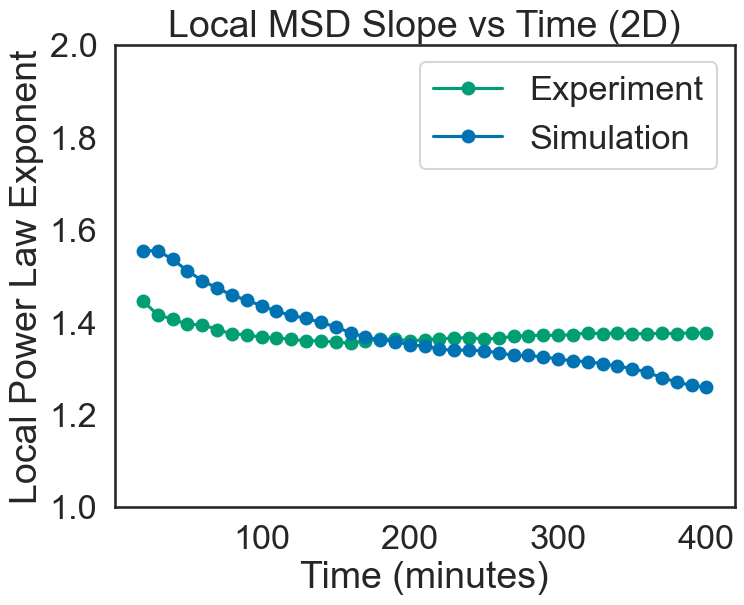

In [54]:
# Calculate local slope (alpha) for MSD vs time in sliding windows of 10 minutes for both experiment and simulation

def calc_local_alpha(dt_vals, msd_vals, window_size=10, step_duration=10):
    local_alphas = []
    local_times = []
    n_points = len(dt_vals)
    window_pts = window_size // step_duration
    for i in range(n_points - window_pts):
        window_dt = dt_vals[i:i + window_pts + 1]
        window_msd = msd_vals[i:i + window_pts + 1]
        if np.all(window_msd > 0):
            log_dt = np.log(window_dt)
            log_msd = np.log(window_msd)
            slope, _ = np.polyfit(log_dt, log_msd, 1)
            local_alphas.append(slope)
            local_times.append(window_dt[len(window_dt)//2])
    return np.array(local_times), np.array(local_alphas)

# Experimental data
dt_exp = msd_exp['dt'][:40].values
msd_exp_vals = msd_exp['msd'][:40].values
local_times_exp, local_alphas_exp = calc_local_alpha(dt_exp, msd_exp_vals, window_size=10, step_duration=step_duration)

# Simulation data
dt_sim = msd_sim['dt'][:40].values
msd_sim_vals = msd_sim['msd'][:40].values
local_times_sim, local_alphas_sim = calc_local_alpha(dt_sim, msd_sim_vals, window_size=10, step_duration=step_duration)

plt.figure(figsize=(8, 6))
plt.plot(local_times_exp, local_alphas_exp, marker='o', linestyle='-', label='Experiment', color=color_map["2D BTrack Tracking"])
plt.plot(local_times_sim, local_alphas_sim, marker='o', linestyle='-', label='Simulation', color=color_map["Simulation"])
plt.ylim(1, 2)
plt.xlabel('Time (minutes)')
plt.ylabel('Local Power Law Exponent')
plt.title('Local MSD Slope vs Time (2D)')
plt.legend()
plt.show()